In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

# 1. import dependencies

In [2]:
df = pd.read_csv('updated_pollution_dataset.csv')
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


# 2. EDA

## 2.1 Thống kê mô tả dữ liệu 

In [3]:
df.shape

(5000, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [5]:
df.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [6]:
df.isnull().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

In [7]:
df["Air Quality"].value_counts()

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

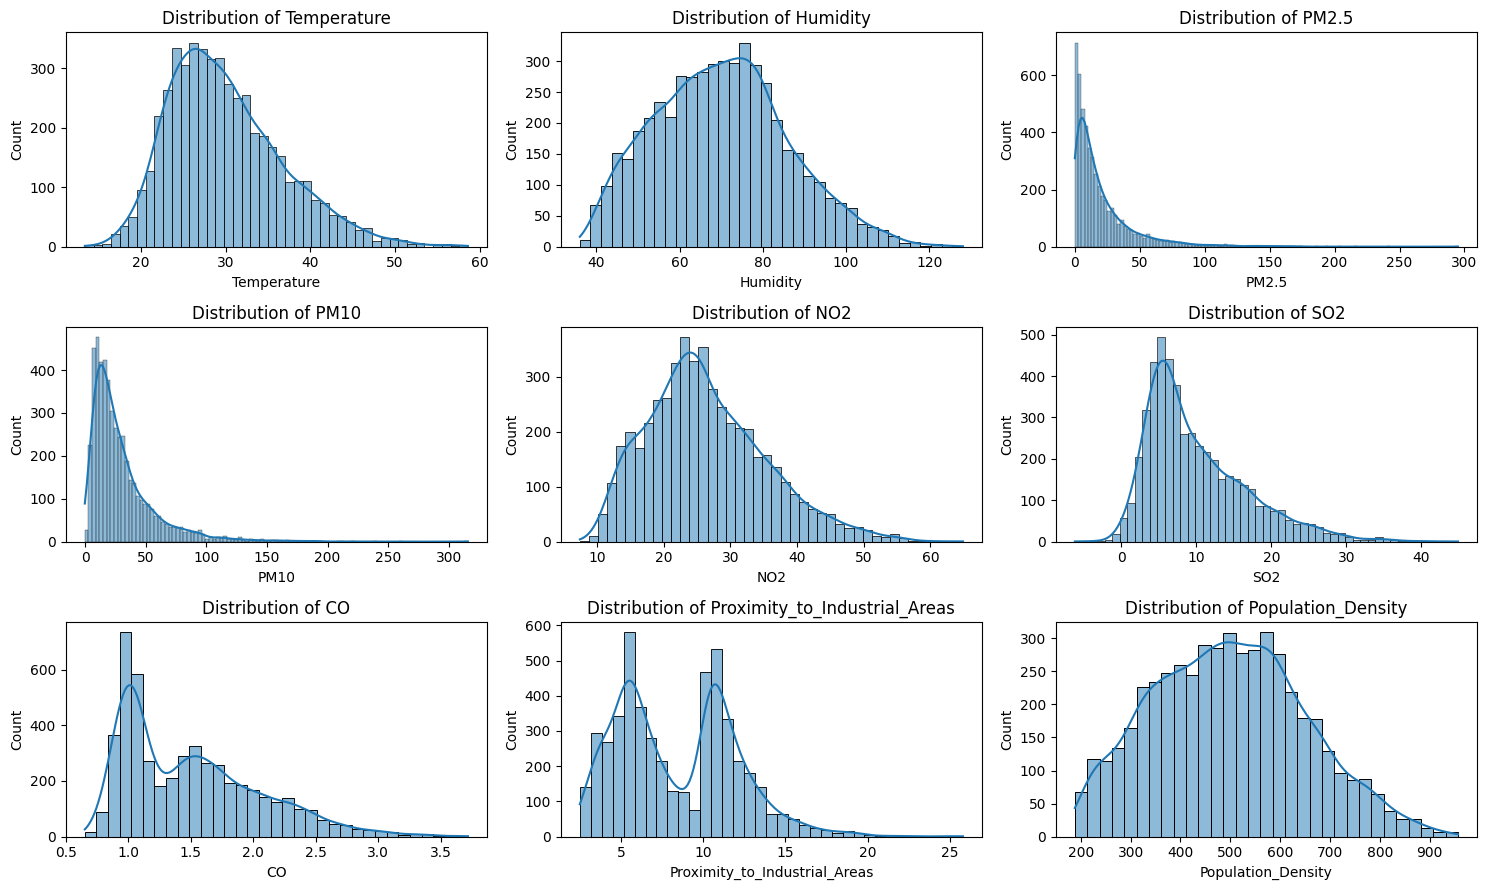

In [8]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
num_columns = len(numerical_columns)
num_rows = (num_columns // 3) + (1 if num_columns % 3 != 0 else 0)  # Round up if there's a remainder
num_cols = 3  # Fix number of columns to 3

# Create the subplots with dynamic grid size
plt.figure(figsize=(15, 3 * num_rows))  # Adjust the figure size based on rows
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig("dis.png")
plt.show()

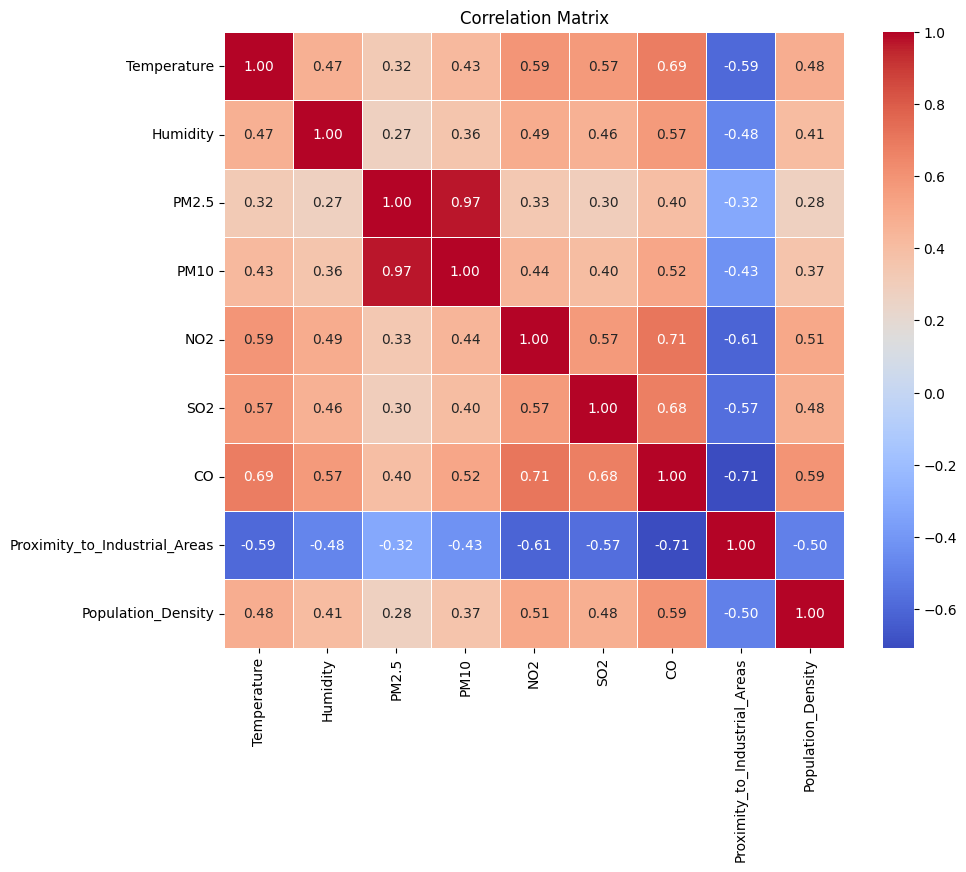

In [9]:
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig("corr.png")
plt.show()

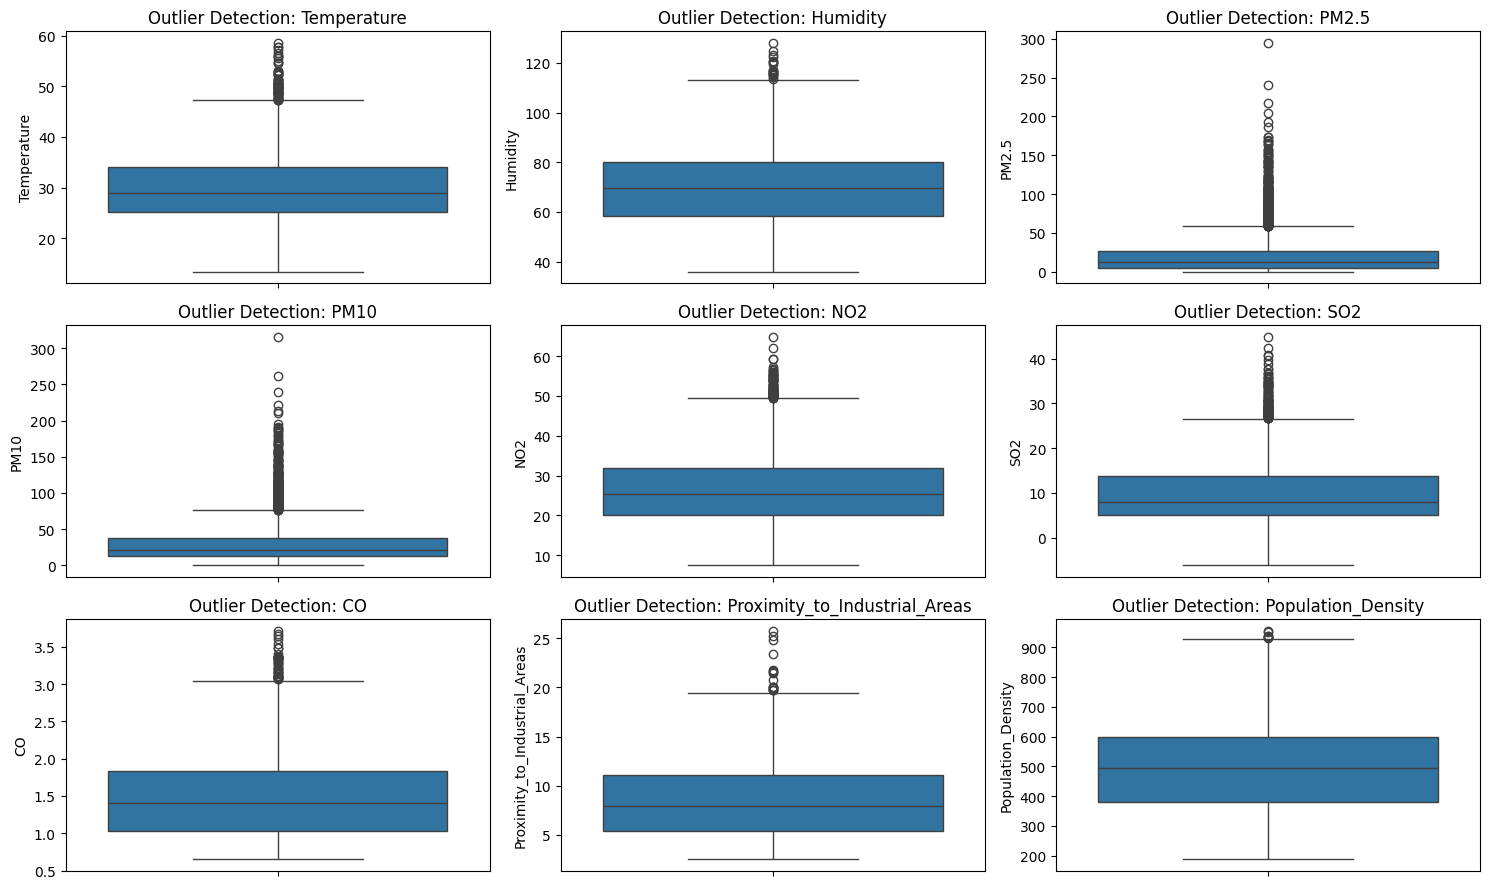

In [10]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns for subplots dynamically
num_columns = len(numerical_columns)
num_rows = (num_columns // 3) + (1 if num_columns % 3 != 0 else 0)  # Round up if there's a remainder
num_cols = 3  # Fix number of columns to 3

# Create the subplots with dynamic grid size
plt.figure(figsize=(15, 3 * num_rows))  # Adjust the figure size based on rows
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(df[column])
    plt.title(f'Outlier Detection: {column}')
plt.tight_layout()
plt.savefig("out.png")
plt.show()

# 3. Xử lí dữ liệu

In [11]:
mapping = {'Good': 0, 'Moderate': 1, 'Poor': 2,'Hazardous' : 3}
df['Air Quality'] = df['Air Quality'].map(mapping)
df['Air Quality']

0       1
1       1
2       1
3       0
4       0
       ..
4995    3
4996    1
4997    1
4998    0
4999    1
Name: Air Quality, Length: 5000, dtype: int64

In [12]:
X = df.drop(['Air Quality'], axis=1)
y = df[['Air Quality']]

In [13]:
X_train, x_test, y_train, y_test = train_test_split (X, y, test_size=0.25, random_state = 42)

In [14]:
smote = SMOTE(random_state=42) # Áp dụng SMOTE để tăng mẫu lớp thiểu số X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [15]:
X_train_smote.shape, y_train_smote.shape, y_train_smote.value_counts()

((5968, 9),
 (5968, 1),
 Air Quality
 0              1492
 1              1492
 2              1492
 3              1492
 Name: count, dtype: int64)

In [16]:
# chuẩn hóa với standardScaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train_smote)
X_test_st= scaler.transform(x_test)

# 4. Xây dựng mô hình

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

selected_features = []

# Define the machine learning model (in this case, a Random Forest Classifier)
model = RandomForestClassifier()

# Define the number of features you want to select
num_features_to_select = 5

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(X.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, X.iloc[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature names:", X.columns[selected_features].tolist())

Selected Feature 1: 6, Mean Accuracy: 0.8316
Selected Feature 2: 7, Mean Accuracy: 0.8864
Selected Feature 3: 4, Mean Accuracy: 0.9224
Selected Feature 4: 1, Mean Accuracy: 0.9340
Selected Feature 5: 5, Mean Accuracy: 0.9418
Selected feature names: ['CO', 'Proximity_to_Industrial_Areas', 'NO2', 'Humidity', 'SO2']


In [18]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the machine learning model (in this case, a Random Forest Classifier)
model = RandomForestClassifier()

# Specify the number of features you want to retain
num_features_to_retain = 5

# Initialize the RFE selector with the model and the number of features to retain
rfe = RFE(estimator=model, n_features_to_select=num_features_to_retain)

# Fit the RFE selector to your data
rfe.fit(X, y)

# Get the selected features
selected_features = np.where(rfe.support_)[0]


# Evaluate model performance with the selected features using cross-validation
scores = cross_val_score(model, X.iloc
                         [:, selected_features], y, cv=5, scoring='accuracy')
mean_accuracy = np.mean(scores)
print(f"Mean Accuracy with Selected Features: {mean_accuracy:.4f}")
print("Selected feature names:", X.columns[selected_features].tolist())

Mean Accuracy with Selected Features: 0.9426
Selected feature names: ['Temperature', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas']


## Model

In [23]:
# import các thư viện cần thiết 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score # hàm tính toán độ chính xác của mô hình phân loại
from sklearn.metrics import classification_report # hàm in ra báo cáo phân loại cho từng lớp về các chỉ số precision, recall, f1 - score, support
from sklearn.preprocessing import LabelEncoder # mã hóa các biến phân loại thành giá trị số
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

In [24]:
k_fold = 5
random_state = 42

In [27]:
kfold = KFold (n_splits = k_fold, shuffle = True, random_state = random_state)
print (f'+X_train: {len(X_train_smote)}')
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_smote, y_train_smote)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass 

+X_train: 5968
Fold 0: 
+ train_idx: [   0    1    2 ... 5963 5966 5967]
+ valid_idx: [   8   14   15 ... 5960 5964 5965]
+ train / valid: [   8   14   15 ... 5960 5964 5965]
Fold 1: 
+ train_idx: [   0    1    2 ... 5964 5965 5966]
+ valid_idx: [  12   19   25 ... 5961 5962 5967]
+ train / valid: [  12   19   25 ... 5961 5962 5967]
Fold 2: 
+ train_idx: [   1    2    3 ... 5965 5966 5967]
+ valid_idx: [   0    6    7 ... 5955 5957 5963]
+ train / valid: [   0    6    7 ... 5955 5957 5963]
Fold 3: 
+ train_idx: [   0    3    4 ... 5965 5966 5967]
+ valid_idx: [   1    2   10 ... 5951 5953 5958]
+ train / valid: [   1    2   10 ... 5951 5953 5958]
Fold 4: 
+ train_idx: [   0    1    2 ... 5964 5965 5967]
+ valid_idx: [   3    4    5 ... 5956 5959 5966]
+ train / valid: [   3    4    5 ... 5956 5959 5966]


In [28]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['kNN']   = KNeighborsClassifier()
baseline_models['Naive Bayes']  = GaussianNB()
baseline_models['SVM']  = SVC(random_state=random_state)
baseline_models['DT'] = DecisionTreeClassifier(random_state=random_state)
baseline_models['RF']   =RandomForestClassifier(random_state=random_state)
baseline_models['AdaBoost']  = AdaBoostClassifier()
baseline_models['GB']   = GradientBoostingClassifier()
baseline_models['LDA']   =  LinearDiscriminantAnalysis()
baseline_models['LR']   = LogisticRegression()
baseline_models['XGB']   =  XGBClassifier(random_state=42)
# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    # Tách X_train, y_train thành 2 tập train, valid trên từng fold
    # Với mỗi fold, train cho huấn luyện, valid cho lượng giá và điều chỉnh tham số
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train_smote, y_train_smote)):
        # Chia 2 tập thành train/valid
        X1_train, y1_train = X_train_smote.iloc[train_idx], y_train_smote.iloc[train_idx]
        X1_valid, y1_valid = X_train_smote.iloc[valid_idx], y_train_smote.iloc[valid_idx]


        # Lấy mô hình khởi tạo
        model_clf = sklearn.base.clone(baseline_models[model_name])

        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)

        # Lượng giá mô hình
        y1_pred_valid = model_clf.predict(X1_valid)

        # Tính toán metrics: accuracy
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)

        # Lưu metrics trên từng fold
        baseline_results[model_name].append(valid_acc)

        pass # fold
    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    # baseline_results[name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train_smote, y_train_smote)
    pass # model

Model [kNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.8844221105527639, 0.8936348408710217, 0.864321608040201, 0.8709136630343671, 0.856663872590109]
+ mean_acc = 0.873991 +/- 0.013401

Model [Naive Bayes]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ acc = [0.9296482412060302, 0.9061976549413735, 0.8994974874371859, 0.9069572506286673, 0.9044425817267393]
+ mean_acc = 0.909349 +/- 0.010477

Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ acc = [0.7571189279731994, 0.7395309882747069, 0.7345058626465661, 0.732606873428332, 0.7443419949706622]
+ mean_acc = 0.741621 +/- 0.008762

Model [DT]:
+ params

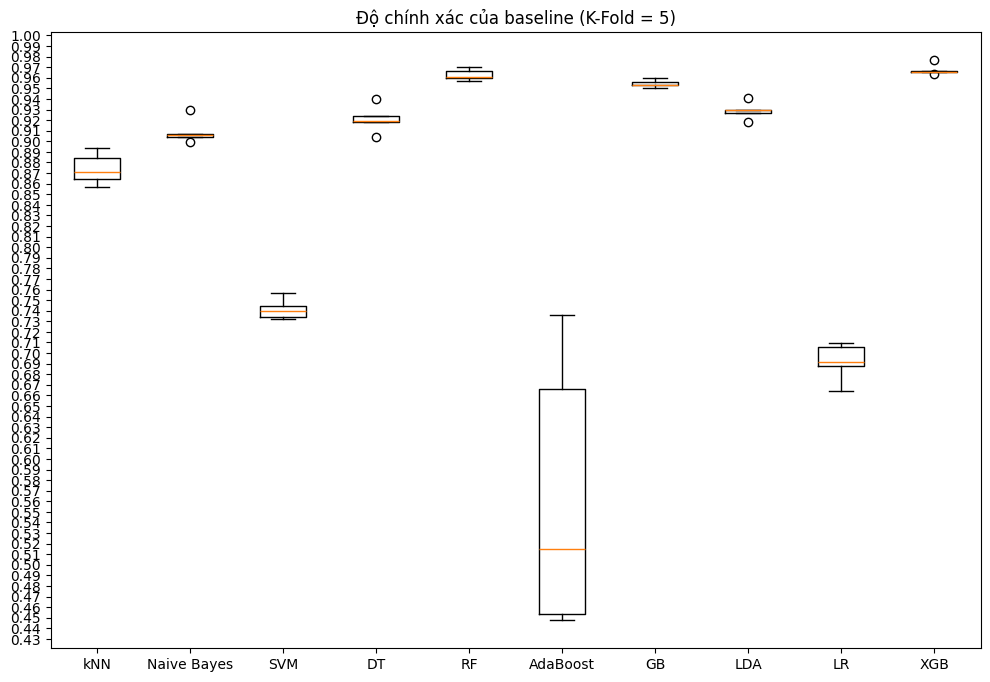

In [29]:
# In biểu đồ box-plot trên độ chính xác với k-fold
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
plt.boxplot(baseline_results.values())
plt.gca().set_xticklabels(baseline_results.keys())
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.title(f'Độ chính xác của baseline (K-Fold = {k_fold})')
plt.show()

In [30]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
}

tunning_models  = {}
tunning_params  = {}

# khởi tạo các tham số mặc định
# KNN
tunning_models['kNN'] = KNeighborsClassifier()
tunning_params['kNN'] = {
    'n_neighbors': [2, 4, 6, 8, 10],
}

# Naive Bayes
tunning_models['Naive Bayes'] = GaussianNB()
tunning_params['Naive Bayes'] = {
    # GaussianNB không có nhiều tham số để tối ưu
    # Thêm vào đây nếu cần
}


# Decision Tree
tunning_models['DT'] = DecisionTreeClassifier(random_state=random_state)
tunning_params['DT'] = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Random Forest
tunning_models['RF'] = RandomForestClassifier(random_state=random_state)
tunning_params['RF'] = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
}

# AdaBoost
tunning_models['AdaBoost'] = AdaBoostClassifier(random_state=random_state)
tunning_params['AdaBoost'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}

# Gradient Boosting
tunning_models['GB'] = GradientBoostingClassifier(random_state=random_state)
tunning_params['GB'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
}

# Linear Discriminant Analysis
tunning_models['LDA'] = LinearDiscriminantAnalysis()
tunning_params['LDA'] = {
    'solver': ['svd', 'lsqr', 'eigen'],
}


# Logistic Regression
tunning_models['LR'] = LogisticRegression(random_state=random_state)
tunning_params['LR'] = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
}
tunning_models['XGBoost'] = XGBClassifier(eval_metric='mlogloss')
tunning_params['XGBoost'] = {
    'n_estimators': [50, 100, 200],  # Số lượng cây
    'learning_rate': [0.01, 0.1, 0.3],  # Tốc độ học
    'max_depth': [3, 6, 9],  # Độ sâu của cây
    # 'subsample': [0.8, 0.9, 1.0],  # Tỷ lệ mẫu sử dụng trong mỗi cây
    # 'colsample_bytree': [0.8, 0.9, 1.0],  # Tỷ lệ cột sử dụng trong mỗi cây
    'gamma': [0, 0.1, 0.2],  # Điều chỉnh sự phân nhánh của cây
}
for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    grid_clf = GridSearchCV(estimator=model_clf,
                            param_grid=tunning_params[model_name],
                            cv = kfold, scoring="accuracy")
    grid_result = grid_clf.fit(X_train_st, y_train_smote)

    # store best model
    tunning_results["best_clf"][model_name] = grid_clf.best_estimator_

    # get search results
    tunning_results["best_score"][model_name] = grid_result.best_score_


    # information
    print(f'+ Best score: {grid_result.best_score_}')
    print(f'+ Best turnning params: {grid_result.best_params_}')
    print(f'+ Best full params: {grid_clf.best_estimator_.get_params()}')
    print()

    pass

Model [kNN]:
+ Best score: 0.9498996800150514
+ Best turnning params: {'n_neighbors': 2}
+ Best full params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

Model [Naive Bayes]:
+ Best score: 0.9093486431879994
+ Best turnning params: {}
+ Best full params: {'priors': None, 'var_smoothing': 1e-09}

Model [DT]:
+ Best score: 0.9242615704956748
+ Best turnning params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
+ Best full params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

Model [RF]:
+ Best score: 0.9638058973268129
+ Best turnning params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
+ Best full 

Baseline [kNN]
+ acc = 0.793
[[483  24   1   0]
 [ 43 274  58   6]
 [  0  50 141  38]
 [  0   1  38  93]]


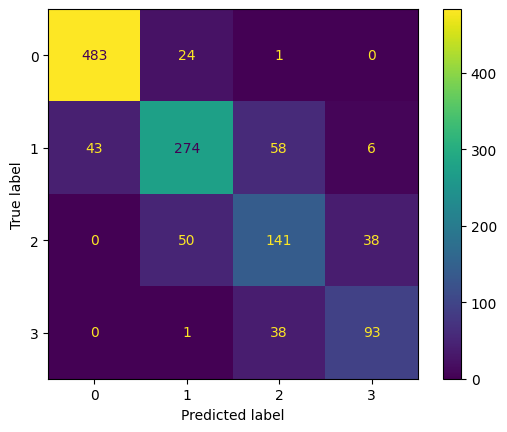

Baseline [Naive Bayes]
+ acc = 0.919
[[502   6   0   0]
 [  2 347  31   1]
 [  0  16 191  22]
 [  0   0  23 109]]


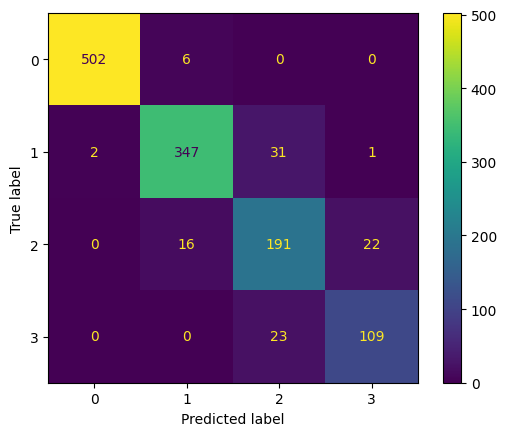

Baseline [SVM]
+ acc = 0.777
[[471  37   0   0]
 [ 52 263  66   0]
 [  0  50 141  38]
 [  0   1  35  96]]


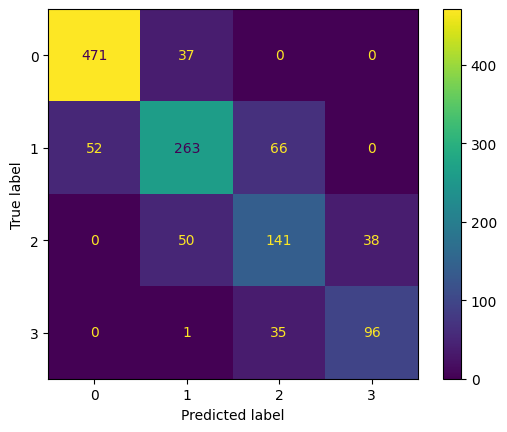

Baseline [DT]
+ acc = 0.914
[[506   2   0   0]
 [  3 347  31   0]
 [  0  15 180  34]
 [  0   0  23 109]]


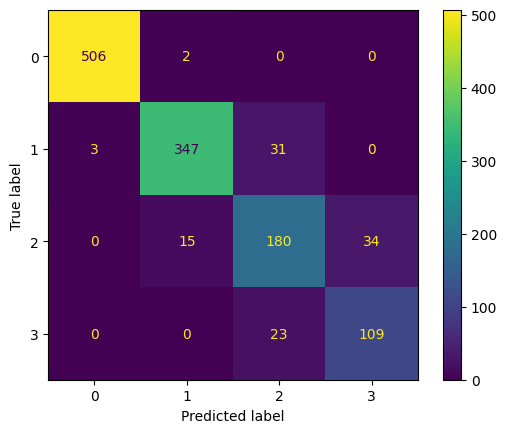

Baseline [RF]
+ acc = 0.950
[[508   0   0   0]
 [  0 364  17   0]
 [  0   9 196  24]
 [  0   0  13 119]]


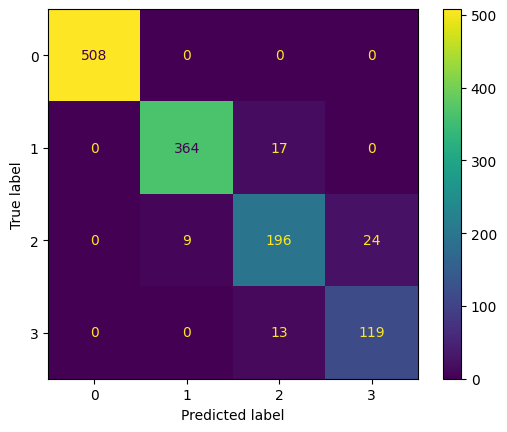

Baseline [AdaBoost]
+ acc = 0.360
[[106 402   0   0]
 [  0 152 226   3]
 [  0   9  64 156]
 [  0   1   3 128]]


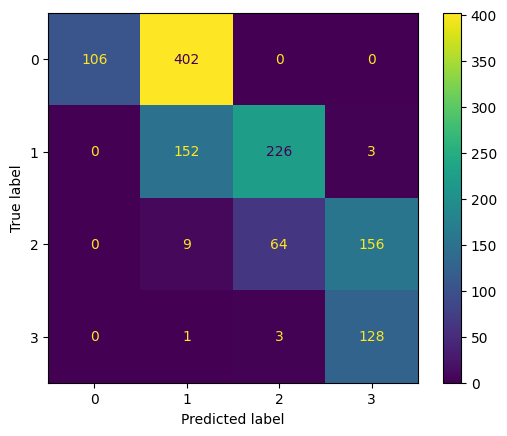

Baseline [GB]
+ acc = 0.951
[[508   0   0   0]
 [  2 360  19   0]
 [  0   6 199  24]
 [  0   0  10 122]]


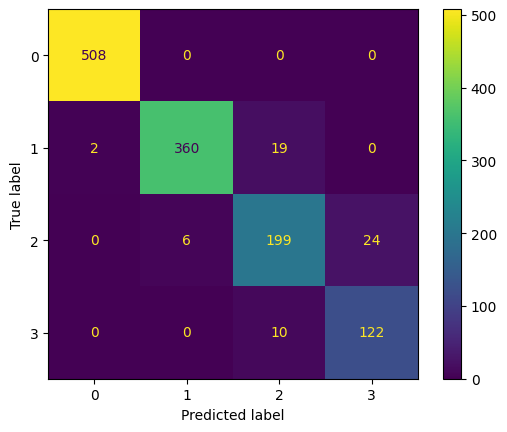

Baseline [LDA]
+ acc = 0.934
[[508   0   0   0]
 [ 11 356  14   0]
 [  1  17 188  23]
 [  0   0  17 115]]


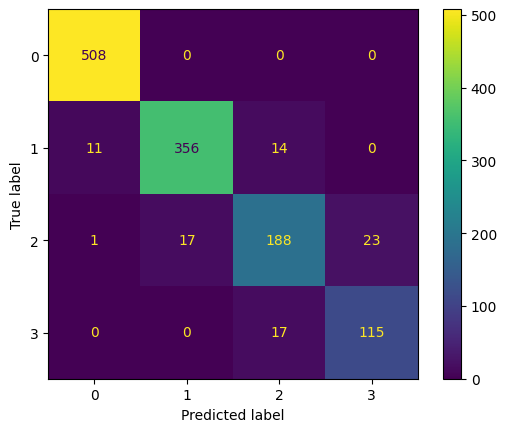

Baseline [LR]
+ acc = 0.739
[[490  18   0   0]
 [ 17 257  93  14]
 [  1  52  85  91]
 [  0  10  30  92]]


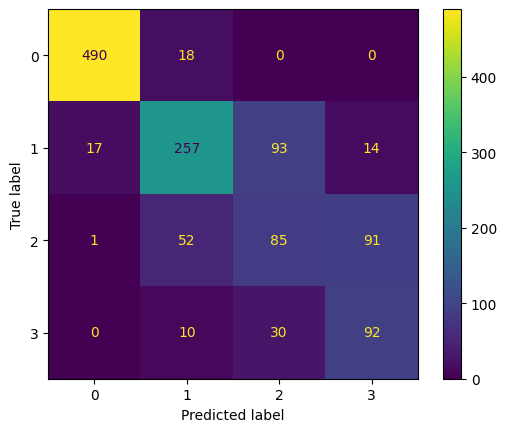

Baseline [XGB]
+ acc = 0.948
[[508   0   0   0]
 [  0 363  18   0]
 [  0  11 197  21]
 [  0   0  15 117]]


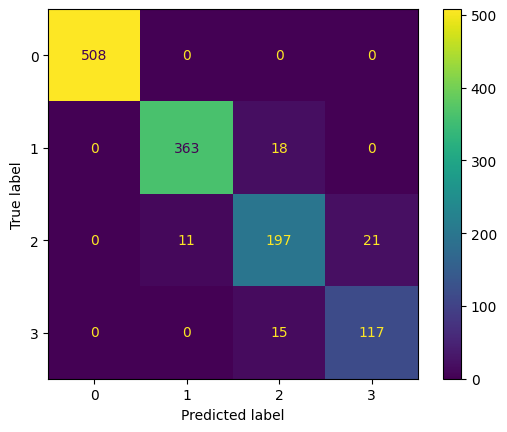

In [31]:
test_models  = {}
test_scores  = {}

# Kiểm tra kết quả trên tập test (baseline)
for model_name in baseline_models:
    model_clf = baseline_models[model_name]
    y_pred_test = model_clf.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Baseline [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

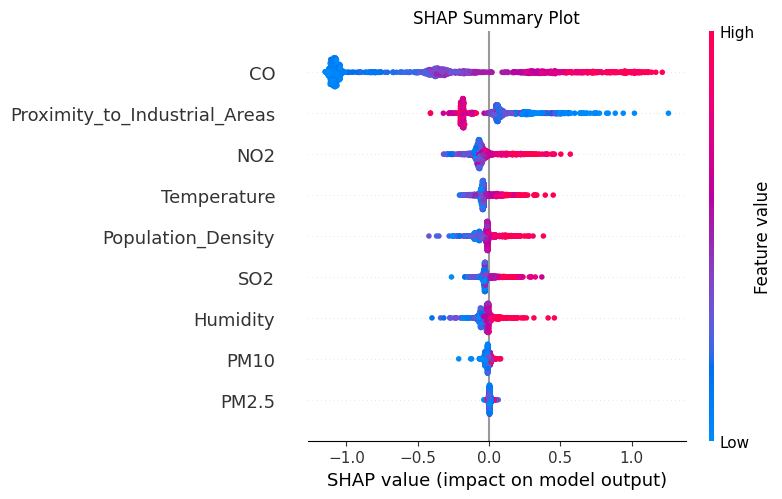

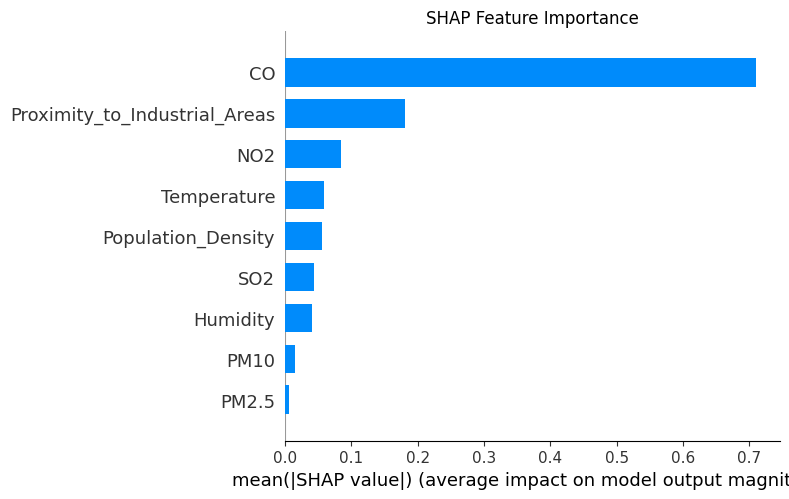

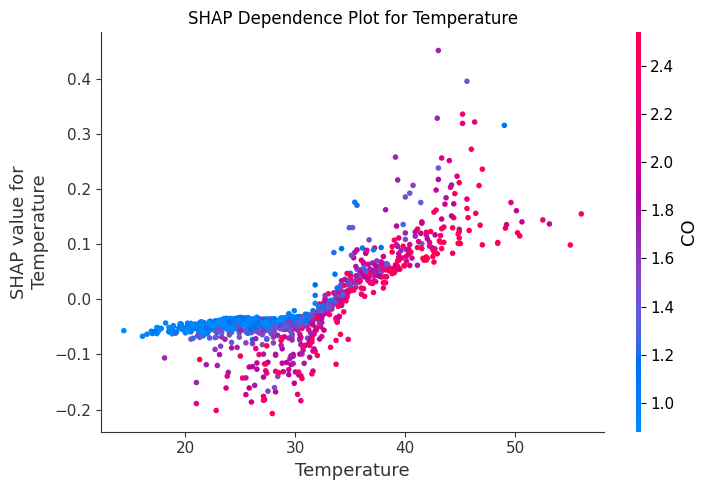

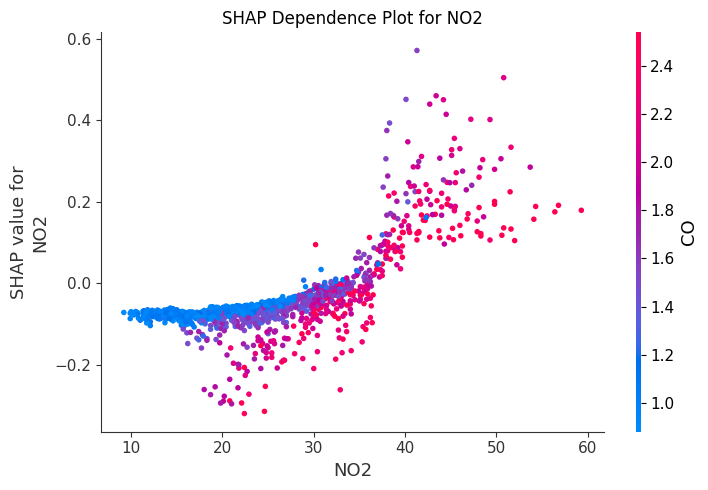

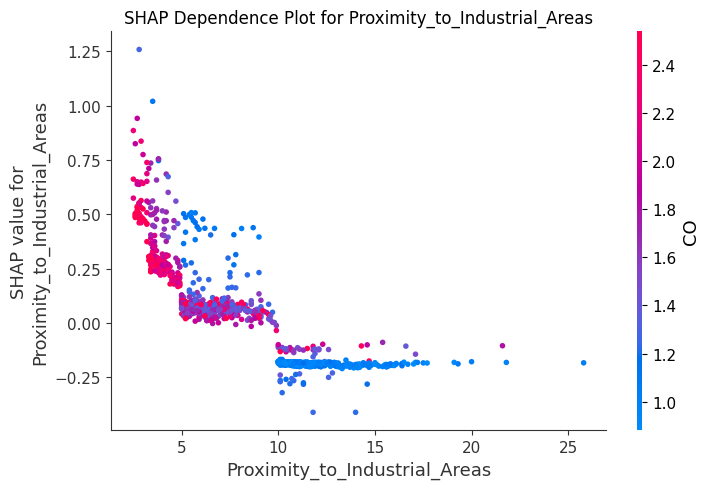

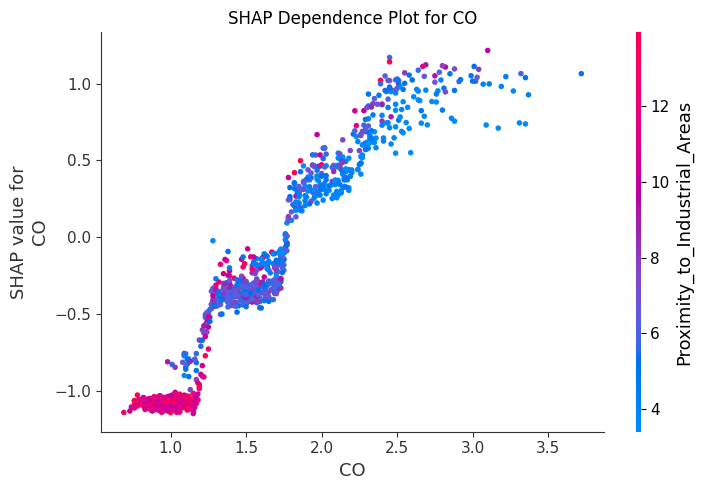


Feature Importance Summary:
                      Feature  Mean Absolute SHAP Value
                           CO                  0.710797
Proximity_to_Industrial_Areas                  0.181162
                          NO2                  0.084507
                  Temperature                  0.058714
           Population_Density                  0.055576
                          SO2                  0.043456
                     Humidity                  0.040699
                         PM10                  0.014897
                        PM2.5                  0.005611

Detailed explanation for sample 0:

Feature values:
Temperature: 31.300
Humidity: 73.400
PM2.5: 72.800
PM10: 88.800
NO2: 54.100
SO2: 17.100
CO: 2.540
Proximity_to_Industrial_Areas: 2.600
Population_Density: 755.000

SHAP values (feature contributions):
Temperature: -0.084
Humidity: -0.032
PM2.5: -0.023
PM10: -0.011
NO2: 0.157
SO2: 0.020
CO: 0.679
Proximity_to_Industrial_Areas: 0.505
Population_Density: 0.09

In [32]:
# Train a random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

def analyze_shap_values(model, X_test, shap_values, feature_names):
    """
    Analyze and visualize SHAP values for a given model
    """
    # Create summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                     show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
    
    # Create bar plot of feature importance
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                     plot_type="bar", show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Create detailed analysis for top 3 most important features
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[-4:]
    
    for idx in top_features_idx:
        feature_name = feature_names[idx]
        shap.dependence_plot(idx, shap_values, X_test, feature_names=feature_names,
                           show=False)
        plt.title(f"SHAP Dependence Plot for {feature_name}")
        plt.tight_layout()
        plt.show()
        
    # Calculate and return feature importance summary
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Mean Absolute SHAP Value': mean_abs_shap
    }).sort_values('Mean Absolute SHAP Value', ascending=False)
    
    return feature_importance

# Generate visualizations and get feature importance
feature_importance = analyze_shap_values(model, x_test, shap_values, X.columns)

# Print feature importance summary
print("\nFeature Importance Summary:")
print(feature_importance.to_string(index=False))

# Example of explaining a single prediction
sample_idx = 0
print(f"\nDetailed explanation for sample {sample_idx}:")
print("\nFeature values:")
for feature, value in x_test.iloc[sample_idx].items():
    print(f"{feature}: {value:.3f}")

print("\nSHAP values (feature contributions):")
for feature, shap_value in zip(x_test.columns, shap_values[sample_idx]):
    print(f"{feature}: {shap_value:.3f}")